In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from IPython.display import clear_output
import pooch
import os

import xarray as xr
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Make True if you want to train the model from scratch. It should take 30 min to train.
train_mode = False

%matplotlib inline

## Functions on background

In [2]:
def load_from_pooch(file):
    nc_file = xr.open_dataset(file)
    return nc_file

# Function to scale the field based on the 90th percentile of its maximum
def scale_field(field):
    max_90th_percentile = np.percentile(field.max(axis=(1, 2)), 90)
    # print(max_90th_percentile)
    return field / max_90th_percentile

# Function to augment the data by flipping
def augment_data(inputs, outputs):
    aug_inputs, aug_outputs = [], []

    for inp, out in zip(inputs, outputs):
        # Original data
        aug_inputs.append(inp)
        aug_outputs.append(out)

        # Horizontal flip
        aug_inputs.append(np.flip(inp, axis=2))  # Flip along x-axis
        aug_outputs.append(np.flip(out, axis=2))

        # Vertical flip
        aug_inputs.append(np.flip(inp, axis=1))  # Flip along y-axis
        aug_outputs.append(np.flip(out, axis=1))

    return np.array(aug_inputs), np.array(aug_outputs)

def prepare_data(merged_data):
    # Step 1: Extract the input and output fields
    thk = merged_data['thk'].values            # Ice thickness
    slopsurfx = merged_data['slopsurfx'].values  # Surface slope in x
    slopsurfy = merged_data['slopsurfy'].values  # Surface slope in y
    ubar = merged_data['ubar'].values          # Velocity x component
    vbar = merged_data['vbar'].values          # Velocity y component
    usurf = merged_data['usurf'].values
    
    # Step 2: Scale each field using the 90th percentile of its maximum
    thk_scaled = scale_field(thk)
    slopsurfx_scaled = scale_field(slopsurfx)
    slopsurfy_scaled = scale_field(slopsurfy)
    ubar_scaled = scale_field(ubar)
    vbar_scaled = scale_field(vbar)
    usurf_scaled = scale_field(usurf)

    # Step 3: Stack inputs and outputs after scaling
    inputs_scaled = np.stack([thk_scaled, slopsurfx_scaled, slopsurfy_scaled], axis=-1)  # Shape: (time, y, x, 3)
    outputs_scaled = np.stack([ubar_scaled, vbar_scaled], axis=-1)  # Shape: (time, y, x, 2)

    return inputs_scaled, outputs_scaled

def augment_data_for_training(inputs_scaled, outputs_scaled):
    # Split index for 90-10 split
    split_idx = int(0.9 * inputs_scaled.shape[0])

    # Train-test split for inputs
    X_train = inputs_scaled[:split_idx]
    X_test = inputs_scaled[split_idx:]

    # Train-test split for outputs
    y_train = outputs_scaled[:split_idx]
    y_test = outputs_scaled[split_idx:]

    # Apply data augmentation
    X_train_aug, y_train_aug = augment_data(X_train, y_train)
    X_test_aug, y_test_aug = augment_data(X_test, y_test)

    return X_test_aug, X_train_aug, y_test_aug, y_train_aug

def plot_comparison(thk, slopesurx, slopesury, true_ubar, true_vbar, pred_ubar, pred_vbar, time_idx=0):
    fig, axs = plt.subplots(3, 3, figsize=(12, 7))

    # Plot inputs with individual color bars
    im = axs[0, 0].imshow(thk[time_idx, :, :], cmap='Blues')
    axs[0, 0].set_title('Ice Thickness (thk)')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('y')
    fig.colorbar(im, ax=axs[0, 0])

    im = axs[0, 1].imshow(slopesurx[time_idx, :, :], cmap='RdBu')
    axs[0, 1].set_title('Surface Slope x (slopesurx)')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('y')
    fig.colorbar(im, ax=axs[0, 1])

    im = axs[0, 2].imshow(slopesury[time_idx, :, :], cmap='RdBu')
    axs[0, 2].set_title('Surface Slope y (slopesury)')
    axs[0, 2].set_xlabel('x')
    axs[0, 2].set_ylabel('y')
    fig.colorbar(im, ax=axs[0, 2])

    # Determine the shared vmin and vmax for velocity comparisons
    vmin_ubar = min(true_ubar.min(), pred_ubar.min())
    vmax_ubar = max(true_ubar.max(), pred_ubar.max())
    vmin_vbar = min(true_vbar.min(), pred_vbar.min())
    vmax_vbar = max(true_vbar.max(), pred_vbar.max())

    # Plot true outputs with shared color bars
    im_ubar_true = axs[1, 0].imshow(true_ubar[time_idx, :, :], cmap='viridis', vmin=vmin_ubar, vmax=vmax_ubar)
    axs[1, 0].set_title('True Velocity x (ubar)')
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('y')
    fig.colorbar(im_ubar_true, ax=axs[1, 0])

    im_vbar_true = axs[2, 0].imshow(true_vbar[time_idx, :, :], cmap='viridis', vmin=vmin_vbar, vmax=vmax_vbar)
    axs[2, 0].set_title('True Velocity y (vbar)')
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel('y')
    fig.colorbar(im_vbar_true, ax=axs[2, 0])
    
    # Plot predicted outputs with the same color scales
    im_ubar_pred = axs[1, 1].imshow(pred_ubar[time_idx, :, :], cmap='viridis', vmin=vmin_ubar, vmax=vmax_ubar)
    axs[1, 1].set_title('Predicted Velocity x (ubar)')
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('y')
    fig.colorbar(im_ubar_pred, ax=axs[1, 1])

    im_vbar_pred = axs[2, 1].imshow(pred_vbar[time_idx, :, :], cmap='viridis', vmin=vmin_vbar, vmax=vmax_vbar)
    axs[2, 1].set_title('Predicted Velocity y (vbar)')
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel('y')
    fig.colorbar(im_vbar_pred, ax=axs[2, 1])

    # Plot difference between true and predicted velocities
    im_ubar_diff = axs[1, 2].imshow(true_ubar[time_idx, :, :] - pred_ubar[time_idx, :, :], cmap='RdBu')
    axs[1, 2].set_title('Difference Velocity x')
    axs[1, 2].set_xlabel('x')
    axs[1, 2].set_ylabel('y')
    fig.colorbar(im_ubar_diff, ax=axs[1, 2])

    im_vbar_diff = axs[2, 2].imshow(true_vbar[time_idx, :, :] - pred_vbar[time_idx, :, :], cmap='RdBu')
    axs[2, 2].set_title('Difference Velocity y')
    axs[2, 2].set_xlabel('x')
    axs[2, 2].set_ylabel('y')
    fig.colorbar(im_vbar_diff, ax=axs[2, 2])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [3]:

# Configuration as a dictionary
config = {
    "nb_layers": 4,               # Number of convolutional layers
    "nb_out_filter": 32,           # Number of output filters for Conv2D
    "conv_ker_size": 3,            # Convolution kernel size
    "activation": "relu",          # Activation function: "relu" or "lrelu"
    "dropout_rate": 0.1,           # Dropout rate
    "regularization": 0.0001       # L2 regularization
}

class CNN(nn.Module):
    def __init__(self, nb_inputs, nb_outputs, config):
        super(CNN, self).__init__()
        
        layers = []
        in_channels = nb_inputs
        for _ in range(config['nb_layers']):
            layers.append(nn.Conv2d(in_channels, config['nb_out_filter'], kernel_size=config['conv_ker_size'], padding='same'))
            layers.append(nn.ReLU() if config['activation'] == "relu" else nn.LeakyReLU(0.01))
            layers.append(nn.Dropout(config['dropout_rate']))
            in_channels = config['nb_out_filter']

        # Output layer
        layers.append(nn.Conv2d(in_channels, nb_outputs, kernel_size=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


## Build, Train, Evaluate the model

In [4]:
# Define the number of input channels (thk, slopsurfx, slopsurfy) and output channels (ubar, vbar)
nb_inputs = 3  # thk, slopsurfx, slopsurfy
nb_outputs = 2  # ubar, vbar

# Instantiate the CNN model
model = CNN(nb_inputs, nb_outputs, config)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

cuda


In [5]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Retrieve the files from the cloud using Pooch
data_url = 'https://unils-my.sharepoint.com/:u:/g/personal/kejdi_lleshi_unil_ch/EZVN0nazQYFMoFkONuM4788BfSsSe3xjB-jSXYW9JibtHw?download=1'
file = pooch.retrieve(data_url, known_hash=None)

# Load and prepare the necessary dataset
merged_data = load_from_pooch(file)

# Prepare data
inputs_scaled, outputs_scaled = prepare_data(merged_data)

In [6]:
# Augment data for training
X_test_aug, X_train_aug, y_test_aug, y_train_aug = augment_data_for_training(inputs_scaled, outputs_scaled)
print(X_train_aug.shape,y_train_aug.shape)# Convert data to PyTorch tensors
X_train_aug = torch.tensor(X_train_aug, dtype=torch.float32).permute(0, 3, 1, 2).to(device)  # (batch, channels, height, width)
y_train_aug = torch.tensor(y_train_aug, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
X_test_aug = torch.tensor(X_test_aug, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_test_aug = torch.tensor(y_test_aug, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
print(X_train_aug.shape,y_train_aug.shape)# Create DataLoader for training and testing
train_loader = DataLoader(TensorDataset(X_train_aug, y_train_aug), batch_size=8, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_aug, y_test_aug), batch_size=8, shuffle=False)

(270, 323, 497, 3) (270, 323, 497, 2)
torch.Size([270, 3, 323, 497]) torch.Size([270, 2, 323, 497])


In [7]:
if not train_mode :
    # Load the model if already trained
    print("Loading the saved model...")
    model = CNN(nb_inputs, nb_outputs, config).to(device)
    model.load_state_dict(torch.load('/home/klleshi/IGEM/InvertedGlacierEvolutionModel/glacier_flow_model.pth'))
    model.eval()
else:
    # Train the model
    print("Training the model...")
    train_losses = []
    val_losses = []
    
    epochs = 150
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, outputs in train_loader:
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = criterion(predictions, outputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, outputs in test_loader:
                predictions = model(inputs)
                loss = criterion(predictions, outputs)
                val_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(test_loader))
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    # Save the model
    torch.save(model.state_dict(), 'glacier_flow_model.pth')

# Plot learning curves
if train_mode:
    plt.figure(figsize=(8, 6))
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


Loading the saved model...


/tmp/ipykernel_8647/584130992.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/klleshi/IGEM/InvertedGlacierEvolutionModel/glacier_

In [8]:
# Set model to evaluation mode
model.eval()


CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [9]:

# Convert the numpy array to a PyTorch tensor and permute the axes
with torch.no_grad():
    X_test_aug_tensor = torch.tensor(X_test_aug, dtype=torch.float32).to(device)  # (batch, channels, height, width)
    predicted_outputs = model(X_test_aug_tensor).cpu().numpy()  # Convert back to numpy



/tmp/ipykernel_8647/1488325450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_aug_tensor = torch.tensor(X_test_aug, dtype=torch.float32).to(device)  # (batch, channels, height, width)


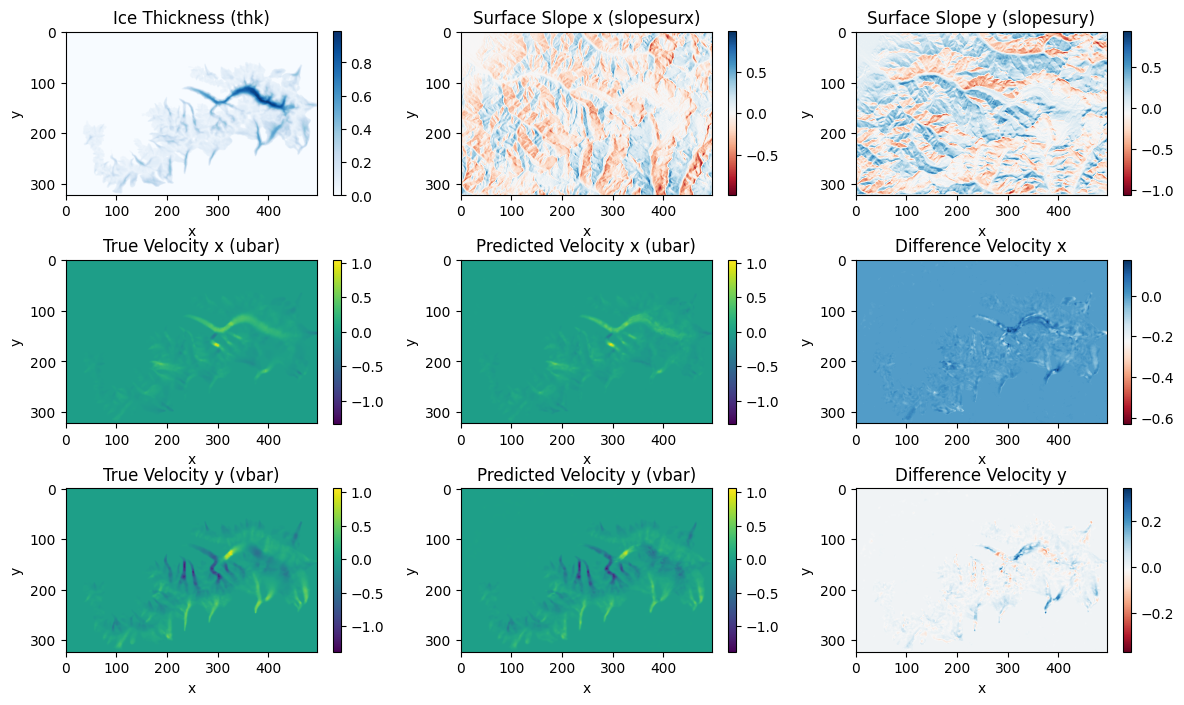

In [10]:
# Separate predicted outputs into ubar and vbar components
pred_ubar = predicted_outputs[:, 0, :, :]  # First channel is ubar
pred_vbar = predicted_outputs[:, 1, :, :]  # Second channel is vbar

# Ensure the data is moved back to CPU for plotting
X_test_aug_cpu = X_test_aug.cpu().numpy()  # Convert the test inputs to numpy on CPU
y_test_aug_cpu = y_test_aug.cpu().numpy()  # Convert the test outputs to numpy on CPU

# Call the plot function for a specific time index, e.g., 0
time_idx = 2
plot_comparison(X_test_aug_cpu[:,0,:,:], X_test_aug_cpu[:,1,:,:], X_test_aug_cpu[:,2,:,:],
                y_test_aug_cpu[:,0,:,:], y_test_aug_cpu[:,1,:,:], 
                pred_ubar, pred_vbar, time_idx)
